<a href="https://colab.research.google.com/github/Jashwanth63/Custom-Model-for-classification-of-Image-Data-without-using-Convolutional-Neural-Networks/blob/main/210367252_Coursework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch_optimizer

In [4]:
import pickle
import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import tqdm as tqdm
import torch_optimizer as optim
from torch.nn.modules.loss import KLDivLoss
from torch.nn.modules.loss import MultiLabelMarginLoss

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

cuda:0


In [6]:
#READ AND WRITE PROCESSED DATASET 

def write_vectorised(data, data_usecase):
  if data_usecase == "TRAIN":
    with open("vectorised_train.txt", "wb") as file_pointer:
      pickle.dump(data, file_pointer)
  elif data_usecase == "TEST":
    with open("vectorised_test.txt","wb") as file_pointer:
      pickle.dump(data, file_pointer)
      
def read_vectorised(data_usecase):
  if data_usecase == "TRAIN":
    with open("vectorised_train.txt", "rb") as file_pointer:
      return pickle.load(file_pointer)
  elif data_usecase == "TEST":
    with open("vectorised_test.txt","rb") as file_pointer:
      return pickle.load(file_pointer)


In [7]:
def download_data(b_size=64):  
    """Download the Fashion-MNIST dataset and then load it into memory."""
    transformations = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5), (0.5))
                                        ])

    mnist_train = torchvision.datasets.FashionMNIST(".", train = True, transform = transformations, target_transform = transforms.Lambda(
                                                    lambda x:torch.zeros(10, dtype = torch.float64).scatter_(dim = 0, index= torch.tensor(x), value = 1)),
                                                    download = True)
    
    mnist_train = torch.utils.data.DataLoader(mnist_train, batch_size = b_size, shuffle = True, num_workers = 3)

    mnist_test = torchvision.datasets.FashionMNIST(".", train = False, transform = transformations, target_transform = transforms.Lambda( 
                                                    lambda x:torch.zeros(10, dtype = torch.float64).scatter_(dim=0, index = torch.tensor(x), value = 1)), 
                                                   download = True)
    
    mnist_test = torch.utils.data.DataLoader(mnist_test, batch_size=b_size, shuffle = True, num_workers = 3)
    return mnist_train, mnist_test  

In [ ]:
'''
  Used a lambda target_transform to make the labels one-hot encoded. USed two transformations on the dataset
'''

In [8]:
training,  testing = download_data(b_size=64)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [9]:
#STEM MODEL - 2 CLASSES, ONE FOR PATCHING AND ONE INHERITING PYTORCH

class stem_patcher(nn.Module):  #This class will be used for find non-overlapping patches and vectorizing the results
  
  def __init__(self, patch_size, im_size):
    super(stem_patcher, self).__init__()
    #self.data = data
    self.patch_size = patch_size
    self.im_size = im_size
    self.patch_dim = int(patch_size**2)
    self.im_dim = int(im_size**2)
    self.num_patches = int(self.im_dim / self.patch_dim)

  
  
  def patch_tensor_maker(self, image, patch_size, im_size): #This functions finds patches
    elements = []
    for l in range(0, im_size-patch_size+1, patch_size):
      for k in range(0, im_size-patch_size+1, patch_size):
        patch = []
        for i in range(patch_size):
          temp = []
          for j in range(patch_size):
            temp.append(image[l+i][k+j])
          patch.append(temp)
        elements.append(patch)
    return elements


  def patch_maker(self, data):  #This function uses patch_tensor_maker() to find patches, the result is
    data_list_main = list()     #appended to a list which is then converted to a torch tensor. This is returned
    for i, batch in enumerate(data):    #to the caller. Note that the patches are not vectorized here. 
      batch_vectorised = []
      for image in batch[0]:
        im_size = image.size()[1]
        batch_vectorised.append(self.patch_tensor_maker(image.view(im_size, im_size), self.patch_size, im_size))
      main_data = torch.Tensor(batch_vectorised)
      main_labels = batch[1]
      data_list_main.append([main_data, main_labels])
    return data_list_main


class STEM_MAIN(nn.Module):  #This Class passes the vectorized patches into an MLP. 
  def __init__(self, input_size, output_size):
    super(STEM_MAIN, self).__init__()
    #STEM - Linear
    self.linear = nn.Linear(input_size, output_size) 
    self.dropout = nn.Dropout(0.2)
    self.non_linearity = nn.Tanh()
    self.weight_initializer()

  def forward(self, x):
    #STEM FORWARD
    x = self.dropout(self.non_linearity(self.linear(x)))  #Dropout and Non-linearity have been implemented.
    return x
  
  def weight_initializer(self):
    for mod in self.modules():
      if isinstance(mod, nn.Linear):
        nn.init.kaiming_uniform_(mod.weight, mode = 'fan_in')

In [10]:
#BACKBONE MODEL - 1 CLASS 
class BACKBONE(nn.Module):
  
  def __init__(self,  input_size, block_size, output_size):
    super(BACKBONE, self).__init__()
    self.blocks= block_size
    self.input_size = input_size
    self.output_size = output_size
    self.dropout = nn.Dropout(0.2)

    for i in range(self.blocks):
      self.add_module('L1_{0}'.format(i+1), nn.Linear(self.input_size, 128))
      self.add_module('L2_{0}'.format(i+1), nn.Linear(128, 4))
      self.add_module('L3_{0}'.format(i+1), nn.Linear(256, 128))
      self.add_module('L4_{0}'.format(i+1), nn.Linear(128,self.output_size))
      self.add_module('tan1_{0}'.format(i+1), nn.Tanh())
      self.add_module('tan2_{0}'.format(i+1), nn.Tanh())

    self.relu_skip = nn.ReLU() #For Skip Connection

    self.weight_initializer()

  
  def forward(self, x):
    #BACKBONE
    for i in range(self.blocks):
      x = self.call_block(x, block_number = i+1)
    return x
  

  def call_block(self, x, block_number):
    identity = x
    out = x.transpose(1,2)  #X=> X^T
    out = self._modules['L1_{0}'.format(block_number)](out) #matmul(X^T,W1)
    out = self._modules['tan1_{0}'.format(block_number)](out)
    out = self.dropout(out)                   #Added Dropout after Non-Linear Activation
    #x = self.tanactivation(x) #g(X^T,W1) , g() is tanh()
    out = self._modules['L2_{0}'.format(block_number)](out) #01 = g() X W2

    out = out.transpose(1,2) #O1 => O1^T
    out = self._modules['L3_{0}'.format(block_number)](out) #matmul(01, W3)
    out = self._modules['tan2_{0}'.format(block_number)](out) #g(O1, W3), g() is tanh()
    out = self.dropout(out)
    #x = self.tanactivation(x) 
    out = self._modules['L4_{0}'.format(block_number)](out) #O2 = g() X W4
  
    
    out += identity
    out = self.relu_skip(out)        #Using Skip Connections with relu
    
    return out

  
  def weight_initializer(self):
    for mod in self.modules():
      if isinstance(mod, nn.Linear):
        nn.init.kaiming_uniform_(mod.weight, mode = 'fan_in')

In [11]:
#CLASSIFIER MODEL - 1 CLASS
class THE_CLASSIFIER(nn.Module):
  
  def __init__(self, input_size, output_size):
    super(THE_CLASSIFIER, self).__init__()
    #CLASSIFIER
    self.output = nn.Linear(256, 10)
    self.weight_initializer()
  
  def forward(self, x):
    #CLASSIFIER
    x = torch.sum(x, dim=1) / x[1].size()[0]
    x = self.output(x)
    return x

  def weight_initializer(self):
    for mod in self.modules():
      if isinstance(mod, nn.Linear):
        nn.init.kaiming_uniform_(mod.weight, mode = 'fan_in')

In [12]:
class net(nn.Module):
  def __init__(self, input_size, block_size, output_size):
    super(net, self).__init__()
    self.block_size = block_size
    self.input_size = input_size
    self.output_size = output_size

    #MODEL INSTANCES
    self.stem = STEM_MAIN(self.input_size, 256).to(device)
    self.backbone = BACKBONE(4, self.block_size, 256).to(device)
    self.classifier = THE_CLASSIFIER(256, self.output_size).to(device)


  def forward(self, x):
    x = self.stem(x)
    x = self.backbone(x)
    x = self.classifier(x)

    return x

In [13]:
#STEM-PATCHING
PATCH_SIZE = 14
IMAGE_SIZE = 28
PD1 = int(IMAGE_SIZE**2 / PATCH_SIZE**2)
PD2 = int(PATCH_SIZE**2)

#CREATING THE PATCHES
patches = stem_patcher(patch_size = PATCH_SIZE, im_size = IMAGE_SIZE)
train_data = patches.patch_maker(training)
test_data = patches.patch_maker(testing)

#VECTORIZING THE PATCHES
for i in range(len(train_data)):
    train_data[i][0] = train_data[i][0].view(-1, PD1, PD2) 

for i in range(len(test_data)):
    test_data[i][0] = test_data[i][0].view(-1, PD1, PD2)

In [14]:
#RUN THIS AFTER CALCULATING PATCHES
write_vectorised(train_data, data_usecase = "TRAIN")
write_vectorised(test_data, data_usecase = "TEST")

In [15]:
#IF PATCHES HAVE BEEN CALCULATED USED THIS BLOCK FOR READING THEM TO AVOID CALCULATING AGAIN

train_data = read_vectorised(data_usecase = "TRAIN") 
test_data = read_vectorised(data_usecase = "TEST") 

In [16]:
NET = net(input_size = 196, block_size = 8, output_size = 10).to(device) #NOTE: BLOCK SIZE IS 8

In [17]:
for name in NET.modules():
  print(name, )

net(
  (stem): STEM_MAIN(
    (linear): Linear(in_features=196, out_features=256, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (non_linearity): Tanh()
  )
  (backbone): BACKBONE(
    (dropout): Dropout(p=0.2, inplace=False)
    (L1_1): Linear(in_features=4, out_features=128, bias=True)
    (L2_1): Linear(in_features=128, out_features=4, bias=True)
    (L3_1): Linear(in_features=256, out_features=128, bias=True)
    (L4_1): Linear(in_features=128, out_features=256, bias=True)
    (tan1_1): Tanh()
    (tan2_1): Tanh()
    (L1_2): Linear(in_features=4, out_features=128, bias=True)
    (L2_2): Linear(in_features=128, out_features=4, bias=True)
    (L3_2): Linear(in_features=256, out_features=128, bias=True)
    (L4_2): Linear(in_features=128, out_features=256, bias=True)
    (tan1_2): Tanh()
    (tan2_2): Tanh()
    (L1_3): Linear(in_features=4, out_features=128, bias=True)
    (L2_3): Linear(in_features=128, out_features=4, bias=True)
    (L3_3): Linear(in_features=256, out

In [18]:
for name, param in NET.named_parameters():
  print(name," - ", param.size())

stem.linear.weight  -  torch.Size([256, 196])
stem.linear.bias  -  torch.Size([256])
backbone.L1_1.weight  -  torch.Size([128, 4])
backbone.L1_1.bias  -  torch.Size([128])
backbone.L2_1.weight  -  torch.Size([4, 128])
backbone.L2_1.bias  -  torch.Size([4])
backbone.L3_1.weight  -  torch.Size([128, 256])
backbone.L3_1.bias  -  torch.Size([128])
backbone.L4_1.weight  -  torch.Size([256, 128])
backbone.L4_1.bias  -  torch.Size([256])
backbone.L1_2.weight  -  torch.Size([128, 4])
backbone.L1_2.bias  -  torch.Size([128])
backbone.L2_2.weight  -  torch.Size([4, 128])
backbone.L2_2.bias  -  torch.Size([4])
backbone.L3_2.weight  -  torch.Size([128, 256])
backbone.L3_2.bias  -  torch.Size([128])
backbone.L4_2.weight  -  torch.Size([256, 128])
backbone.L4_2.bias  -  torch.Size([256])
backbone.L1_3.weight  -  torch.Size([128, 4])
backbone.L1_3.bias  -  torch.Size([128])
backbone.L2_3.weight  -  torch.Size([4, 128])
backbone.L2_3.bias  -  torch.Size([4])
backbone.L3_3.weight  -  torch.Size([128, 2

In [19]:
optimizer = optim.SWATS(NET.parameters(), amsgrad = True, nesterov = True, weight_decay = 0.001) #SWATS optimizer, Uses Both SGD and ADAM.  
                                                                                                    #MORE DETAIL ABOUT THIS IN MY PDF
loss_function = nn.CrossEntropyLoss()

In [20]:
def accuracy_calculator(hyp, y): #Calculate Accuracy for One-Hot Encoded Vector
  a = torch.argmax(hyp, dim=1)
  b = torch.argmax(y, dim=1)
  return torch.sum(a==b)

In [21]:
per_epoch_training_accuracy = []
per_epoch_training_loss = []
per_epoch_val_accuracy = []

#The Above three lists will be used to plot the evolution graph

def train(out, EPOCHS):  
  accuracy = 0
  for i in range(EPOCHS):
      out.train() #Set model in Train mode
      accuracy = 0
      acc = 0
      for j in tqdm.tqdm(range(len(train_data))): 
          X, y = train_data[j]
          X = X.to(device)
          y = y.to(device)
          out.zero_grad()
          hypothesis = out(X)
          hypothesis.to(device)
          accuracy += accuracy_calculator(hypothesis, y)
          loss = loss_function(hypothesis, y)
          loss.backward()
          optimizer.step()
      
      out.eval()  #Set Model to Eval mode, Dropout Layers are avoided if True
      with torch.no_grad(): 
        for k in range(len(test_data)):
          X_test, y_test = test_data[k]
          X_test = X_test.to(device)
          y_test = y_test.to(device)
          test_hypothesis = out(X_test)
          test_hypothesis.to(device)
          acc += accuracy_calculator(test_hypothesis, y_test)
        print("EPOCHS : ", i+1, "Training LOSS : ",loss)
        accuracy = accuracy/60000
        acc = acc/10000
        print("Training Accuracy is: ", accuracy, "Testing Accuracy is: ", acc)
        #Append The Metrics per epoch to the Lists
        per_epoch_training_accuracy.append(accuracy)
        per_epoch_training_loss.append(loss)
        per_epoch_val_accuracy.append(acc)


def test(out):
  accuracy = 0
  with torch.no_grad():
    for i in tqdm.tqdm(range(len(test_data))):
          X, y = test_data[i]
          X = X.to(device)
          y = y.to(device)
          hypothesis = out(X)
          hypothesis.to(device)
          accuracy += accuracy_calculator(hypothesis, y)
    print(accuracy/10000)

In [22]:
train(NET, EPOCHS = 70)

100%|██████████| 938/938 [00:55<00:00, 17.03it/s]


EPOCHS :  1 Training LOSS :  tensor(0.6629, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.6590, device='cuda:0') Testing Accuracy is:  tensor(0.8094, device='cuda:0')


100%|██████████| 938/938 [00:53<00:00, 17.60it/s]


EPOCHS :  2 Training LOSS :  tensor(0.2587, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8028, device='cuda:0') Testing Accuracy is:  tensor(0.8376, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.72it/s]


EPOCHS :  3 Training LOSS :  tensor(0.2781, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8363, device='cuda:0') Testing Accuracy is:  tensor(0.8512, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.81it/s]


EPOCHS :  4 Training LOSS :  tensor(0.1695, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8520, device='cuda:0') Testing Accuracy is:  tensor(0.8590, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.76it/s]


EPOCHS :  5 Training LOSS :  tensor(0.2137, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8641, device='cuda:0') Testing Accuracy is:  tensor(0.8639, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.78it/s]


EPOCHS :  6 Training LOSS :  tensor(0.1603, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8702, device='cuda:0') Testing Accuracy is:  tensor(0.8679, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.80it/s]


EPOCHS :  7 Training LOSS :  tensor(0.1373, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8748, device='cuda:0') Testing Accuracy is:  tensor(0.8709, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.83it/s]


EPOCHS :  8 Training LOSS :  tensor(0.1190, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8770, device='cuda:0') Testing Accuracy is:  tensor(0.8728, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.82it/s]


EPOCHS :  9 Training LOSS :  tensor(0.1138, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8808, device='cuda:0') Testing Accuracy is:  tensor(0.8770, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.85it/s]


EPOCHS :  10 Training LOSS :  tensor(0.1466, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8831, device='cuda:0') Testing Accuracy is:  tensor(0.8761, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.82it/s]


EPOCHS :  11 Training LOSS :  tensor(0.1333, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8847, device='cuda:0') Testing Accuracy is:  tensor(0.8765, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.80it/s]


EPOCHS :  12 Training LOSS :  tensor(0.1151, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8860, device='cuda:0') Testing Accuracy is:  tensor(0.8810, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.81it/s]


EPOCHS :  13 Training LOSS :  tensor(0.1310, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8880, device='cuda:0') Testing Accuracy is:  tensor(0.8783, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.85it/s]


EPOCHS :  14 Training LOSS :  tensor(0.1678, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8887, device='cuda:0') Testing Accuracy is:  tensor(0.8809, device='cuda:0')


100%|██████████| 938/938 [00:52<00:00, 17.87it/s]


EPOCHS :  15 Training LOSS :  tensor(0.1006, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8916, device='cuda:0') Testing Accuracy is:  tensor(0.8812, device='cuda:0')


100%|██████████| 938/938 [00:46<00:00, 20.23it/s]


EPOCHS :  16 Training LOSS :  tensor(0.0870, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.8926, device='cuda:0') Testing Accuracy is:  tensor(0.8860, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.99it/s]


EPOCHS :  17 Training LOSS :  tensor(0.1163, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9023, device='cuda:0') Testing Accuracy is:  tensor(0.8882, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.46it/s]


EPOCHS :  18 Training LOSS :  tensor(0.0819, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9037, device='cuda:0') Testing Accuracy is:  tensor(0.8890, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.08it/s]


EPOCHS :  19 Training LOSS :  tensor(0.0616, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9057, device='cuda:0') Testing Accuracy is:  tensor(0.8912, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.83it/s]


EPOCHS :  20 Training LOSS :  tensor(0.1040, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9068, device='cuda:0') Testing Accuracy is:  tensor(0.8914, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.01it/s]


EPOCHS :  21 Training LOSS :  tensor(0.0909, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9072, device='cuda:0') Testing Accuracy is:  tensor(0.8907, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.07it/s]


EPOCHS :  22 Training LOSS :  tensor(0.0710, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9079, device='cuda:0') Testing Accuracy is:  tensor(0.8899, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.07it/s]


EPOCHS :  23 Training LOSS :  tensor(0.0795, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9091, device='cuda:0') Testing Accuracy is:  tensor(0.8889, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.99it/s]


EPOCHS :  24 Training LOSS :  tensor(0.0860, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9092, device='cuda:0') Testing Accuracy is:  tensor(0.8930, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.10it/s]


EPOCHS :  25 Training LOSS :  tensor(0.0721, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9106, device='cuda:0') Testing Accuracy is:  tensor(0.8925, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.65it/s]


EPOCHS :  26 Training LOSS :  tensor(0.0611, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9113, device='cuda:0') Testing Accuracy is:  tensor(0.8963, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.58it/s]


EPOCHS :  27 Training LOSS :  tensor(0.0667, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9121, device='cuda:0') Testing Accuracy is:  tensor(0.8917, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.74it/s]


EPOCHS :  28 Training LOSS :  tensor(0.0877, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9122, device='cuda:0') Testing Accuracy is:  tensor(0.8934, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.97it/s]


EPOCHS :  29 Training LOSS :  tensor(0.0442, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9124, device='cuda:0') Testing Accuracy is:  tensor(0.8937, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.71it/s]


EPOCHS :  30 Training LOSS :  tensor(0.0686, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9137, device='cuda:0') Testing Accuracy is:  tensor(0.8954, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.06it/s]


EPOCHS :  31 Training LOSS :  tensor(0.0651, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9149, device='cuda:0') Testing Accuracy is:  tensor(0.8952, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.05it/s]


EPOCHS :  32 Training LOSS :  tensor(0.0836, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9147, device='cuda:0') Testing Accuracy is:  tensor(0.8936, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.76it/s]


EPOCHS :  33 Training LOSS :  tensor(0.0716, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9146, device='cuda:0') Testing Accuracy is:  tensor(0.8936, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.24it/s]


EPOCHS :  34 Training LOSS :  tensor(0.0625, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9171, device='cuda:0') Testing Accuracy is:  tensor(0.8965, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.81it/s]


EPOCHS :  35 Training LOSS :  tensor(0.0528, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9173, device='cuda:0') Testing Accuracy is:  tensor(0.8948, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.45it/s]


EPOCHS :  36 Training LOSS :  tensor(0.0757, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9175, device='cuda:0') Testing Accuracy is:  tensor(0.8936, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.59it/s]


EPOCHS :  37 Training LOSS :  tensor(0.0672, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9172, device='cuda:0') Testing Accuracy is:  tensor(0.8926, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 52.79it/s]


EPOCHS :  38 Training LOSS :  tensor(0.0456, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9181, device='cuda:0') Testing Accuracy is:  tensor(0.8958, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 54.90it/s]


EPOCHS :  39 Training LOSS :  tensor(0.0737, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9193, device='cuda:0') Testing Accuracy is:  tensor(0.8867, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 52.23it/s]


EPOCHS :  40 Training LOSS :  tensor(0.0402, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9180, device='cuda:0') Testing Accuracy is:  tensor(0.8930, device='cuda:0')


100%|██████████| 938/938 [00:18<00:00, 50.62it/s]


EPOCHS :  41 Training LOSS :  tensor(0.0368, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9201, device='cuda:0') Testing Accuracy is:  tensor(0.8945, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 56.64it/s]


EPOCHS :  42 Training LOSS :  tensor(0.0684, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9191, device='cuda:0') Testing Accuracy is:  tensor(0.8960, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 54.63it/s]


EPOCHS :  43 Training LOSS :  tensor(0.0710, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9207, device='cuda:0') Testing Accuracy is:  tensor(0.8938, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 52.22it/s]


EPOCHS :  44 Training LOSS :  tensor(0.0646, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9211, device='cuda:0') Testing Accuracy is:  tensor(0.8934, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 55.10it/s]


EPOCHS :  45 Training LOSS :  tensor(0.0578, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9207, device='cuda:0') Testing Accuracy is:  tensor(0.8953, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 55.33it/s]


EPOCHS :  46 Training LOSS :  tensor(0.0543, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9221, device='cuda:0') Testing Accuracy is:  tensor(0.8950, device='cuda:0')


100%|██████████| 938/938 [00:17<00:00, 54.91it/s]


EPOCHS :  47 Training LOSS :  tensor(0.0614, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9211, device='cuda:0') Testing Accuracy is:  tensor(0.8964, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 57.92it/s]


EPOCHS :  48 Training LOSS :  tensor(0.0914, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9231, device='cuda:0') Testing Accuracy is:  tensor(0.8965, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.21it/s]


EPOCHS :  49 Training LOSS :  tensor(0.0477, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9235, device='cuda:0') Testing Accuracy is:  tensor(0.8975, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.36it/s]


EPOCHS :  50 Training LOSS :  tensor(0.0376, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9236, device='cuda:0') Testing Accuracy is:  tensor(0.8952, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.32it/s]


EPOCHS :  51 Training LOSS :  tensor(0.0401, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9251, device='cuda:0') Testing Accuracy is:  tensor(0.8953, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.92it/s]


EPOCHS :  52 Training LOSS :  tensor(0.0285, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9243, device='cuda:0') Testing Accuracy is:  tensor(0.8962, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.86it/s]


EPOCHS :  53 Training LOSS :  tensor(0.0809, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9248, device='cuda:0') Testing Accuracy is:  tensor(0.8942, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 59.10it/s]


EPOCHS :  54 Training LOSS :  tensor(0.1376, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9243, device='cuda:0') Testing Accuracy is:  tensor(0.8945, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.81it/s]


EPOCHS :  55 Training LOSS :  tensor(0.0698, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9257, device='cuda:0') Testing Accuracy is:  tensor(0.8963, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.44it/s]


EPOCHS :  56 Training LOSS :  tensor(0.0554, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9267, device='cuda:0') Testing Accuracy is:  tensor(0.8950, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.92it/s]


EPOCHS :  57 Training LOSS :  tensor(0.0343, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9265, device='cuda:0') Testing Accuracy is:  tensor(0.8964, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.05it/s]


EPOCHS :  58 Training LOSS :  tensor(0.1456, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9269, device='cuda:0') Testing Accuracy is:  tensor(0.8931, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.40it/s]


EPOCHS :  59 Training LOSS :  tensor(0.0355, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9263, device='cuda:0') Testing Accuracy is:  tensor(0.8971, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.81it/s]


EPOCHS :  60 Training LOSS :  tensor(0.0941, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9268, device='cuda:0') Testing Accuracy is:  tensor(0.8943, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.80it/s]


EPOCHS :  61 Training LOSS :  tensor(0.0692, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9272, device='cuda:0') Testing Accuracy is:  tensor(0.8964, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.24it/s]


EPOCHS :  62 Training LOSS :  tensor(0.0565, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9289, device='cuda:0') Testing Accuracy is:  tensor(0.8964, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.42it/s]


EPOCHS :  63 Training LOSS :  tensor(0.0429, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9280, device='cuda:0') Testing Accuracy is:  tensor(0.8944, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.40it/s]


EPOCHS :  64 Training LOSS :  tensor(0.0502, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9290, device='cuda:0') Testing Accuracy is:  tensor(0.8978, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.44it/s]


EPOCHS :  65 Training LOSS :  tensor(0.0551, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9291, device='cuda:0') Testing Accuracy is:  tensor(0.8945, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.92it/s]


EPOCHS :  66 Training LOSS :  tensor(0.0415, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9287, device='cuda:0') Testing Accuracy is:  tensor(0.8965, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.47it/s]


EPOCHS :  67 Training LOSS :  tensor(0.0400, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9284, device='cuda:0') Testing Accuracy is:  tensor(0.8969, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.52it/s]


EPOCHS :  68 Training LOSS :  tensor(0.0467, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9290, device='cuda:0') Testing Accuracy is:  tensor(0.8959, device='cuda:0')


100%|██████████| 938/938 [00:15<00:00, 58.92it/s]


EPOCHS :  69 Training LOSS :  tensor(0.0572, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9289, device='cuda:0') Testing Accuracy is:  tensor(0.8933, device='cuda:0')


100%|██████████| 938/938 [00:16<00:00, 58.60it/s]


EPOCHS :  70 Training LOSS :  tensor(0.0551, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
Training Accuracy is:  tensor(0.9301, device='cuda:0') Testing Accuracy is:  tensor(0.8954, device='cuda:0')


In [23]:
per_epoch_training_accuracy = [i.cpu().detach().numpy() for i in per_epoch_training_accuracy]

In [24]:
per_epoch_training_loss = [i.cpu().detach().numpy() for i in per_epoch_training_loss]

In [25]:
per_epoch_val_accuracy = [i.cpu().detach().numpy() for i in per_epoch_val_accuracy]

In [29]:
len(per_epoch_val_accuracy)

70

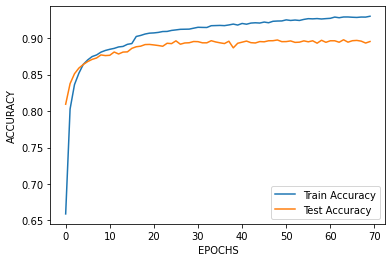


TRAINING ACCURACY: 0.9301

TEST ACCURACY: 0.8954


In [36]:
plt.plot([i for i in range(70)], per_epoch_training_accuracy, label = 'Train Accuracy')
plt.plot([i for i in range(70)], per_epoch_val_accuracy, label = 'Test Accuracy')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()
print("\nTRAINING ACCURACY: {:.4f}".format(per_epoch_training_accuracy[-1].item()))
print("\nTEST ACCURACY: {:.4f}".format(per_epoch_val_accuracy[-1].item()))

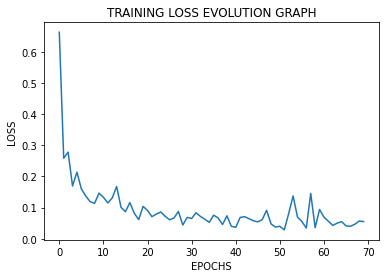


The Training Loss during the last EPOCH: 0.0551


In [38]:
plt.plot([i for i in range(70)], per_epoch_training_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("TRAINING LOSS EVOLUTION GRAPH")
plt.show()
print("\nThe Training Loss during the last EPOCH: {:.4f}".format(per_epoch_training_loss[-1].item()))

# **MODEL METRICS AND IMPLEMENTATION SPECIFICS**

1. EPOCHS:70 
2. BLOCK SIZE: 8
3. SWATS optimizer (Parameters same as above)

4. Transformations: ToTensor() and Normalize(0.5, 0.5)
5. Dropout with P = 0.2 
6. PATCH_SIZE = 14*14 
7. BATCH_SIZE = 64 



>>>> * Training Loss: 0.0551
>>>> * Training Accuracy%: 93.01 
>>>> * Test Accuracy: **89.54%**



##NOTE TO SELF

In [28]:
#1. EPOCHS =100, lr =0.1, BLOCKS =2, accuracy: 73 (Train), 72(Test), Activation: Relu
#1. EPOCHS =100, lr =0.1, BLOCKS =1, accuracy: 74.93 (Train), 73.18(Test), Activation: Relu
#1. EPOCHS =100, lr =0.1, BLOCKS =2, accuracy: 84.82 (Train), 82.34(Test), Activation: TanH
#1. EPOCHS =100, lr =0.13, BLOCKS =3, accuracy: 81.56 (Train), 80.02(Test), Activation: TanH

#IDEAL MODELS:
#1. EPOCHS:100, lr = 0.2, BLOCKS = 2, Accuracy: 83.39 (Train), 81.62 (Test), Activation: TanH, Train Loss: 1.5554 LOG: (01:09 AM, 08-04-2022)
#                                     Top Record: 85.01 (Train), 82.05 (Test), Loss: 1.55490 LOG: (03:07 AM, 08-04-2022)  #Automated Blocks and Used nn.Tanh()

#2. EPOCHS: 100, lr =0.2, BLOCKS = 2, Accuracy: 91.61 (Train), 86.97 (Test), Activation: TanH, Train Loss: 1.5031 / 1.4612 (Lowest) LOG: (03:39 AM, 08-04-2022)
#                                   #Used Kaiming Uniform Initialization 


#3. EPOCHS: 50, AdamW optimizer, Blocks = 2, Accuracy: 92.82 (Train), 86.92 (Test) LOG: (06:28 AM, 08-04-2022)
#4. EPOCHS: 50, SWATS optimizer, Blocks = 2, Accuracy: 98.66 (Train), 87.93 (Test), LOG: (06:54 AM, 08-04-2022)
#5. EPOCHS: 50, SWATS optimizer(L2 regularized 0.001, amsgrad = True, Nesterov = True),
#                               Blocks = 2, Accuracy: 90.97 (Train), 88.17 (Test), Training Loss: 0.1185, Test Loss: 0.2295  LOG: (07:45 AM, 08-04-2022)
#6[CURRENT RECORD]. EPOCHS: 50, SWATS optimizer(L2 regularized 0.001, amsgrad = True, Nesterov = True),
#                               Blocks = 4, Accuracy: 92.64 (Train), 88.54 (Test), Training Loss: 0.0964, Test Loss: 0.2476  LOG: (08:13 AM, 08-04-2022)

#7. {NEW RECORD}: EPOCHS: 50, SWATS '', Blocks = 2, Accuracy: 91.87 (Train), 89.22 (Test), Training Loss: 0.0706, Test Loss: 0.0641
                              # Transformations = ToTensor and Normalize(0.5,0.5), Patch Size = 14*14, Dropout Applied after Non-Linear Activation with P=0.1

#8. Same as No.7, EpoCHS: 100, Blocks:3, Accuracy: 93.03(Train) ,88.28(Test), Training Loss: 0.0718, Test Loss: 0.1021

#NOTE TO SELF:
#1. Linear Layer uses Uniform Weight Initialization, Try out Kaiming_he and Xavier Initialization
#2. I AM AN IDIOT: APPARENTLY CROSSENTROPYLOSS CALCULATES SOFTMAX OUTPUT THEN CALCULATES LOSS, I WAS DOING SOFTMAX MANUALLY. 
#                  THE MODEL CALCULATED SOFTMAX TWICE BEFORE THE OUTPUT, HENCE RESULTING IN HIGH LOSS AND LOW ACCURACY. LOG: (05:52 AM, 08-04-2022)